In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from pandas.core.dtypes.common import is_numeric_dtype

In [2]:
DATA_FOLDER = 'dataset'
INTERMEDIATE_DATA = os.path.join(DATA_FOLDER, 'intermediate_dataset.csv')
DATASET = os.path.join(DATA_FOLDER, 'preprocessed_df.csv')

In [3]:
df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

## Outliers using KNN

In [4]:
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
import networkx as nx

n_neighbors = 5
normalized_df = (df[numerical_attr_list] - df[numerical_attr_list].min()) / (df[numerical_attr_list].max() - df[numerical_attr_list].min())
G = kneighbors_graph(normalized_df.values, n_neighbors=n_neighbors, mode="distance", p=np.inf)
G = nx.DiGraph(G)
dictator = nx.to_dict_of_dicts(G);

In [5]:
score = np.zeros(len(normalized_df))
for element in dictator.keys():
    mean_dist = 0
    for child in dictator[element].keys():
        mean_dist += dictator[element][child]["weight"]/n_neighbors
    score[element] = mean_dist

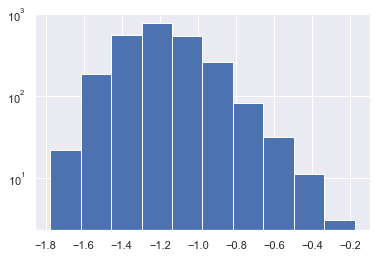

In [6]:
plt.hist(np.log(score))
plt.yscale("log")

In [7]:
from sklearn.manifold import Isomap

reducer = Isomap(n_neighbors=n_neighbors)
embedding = reducer.fit_transform(normalized_df)

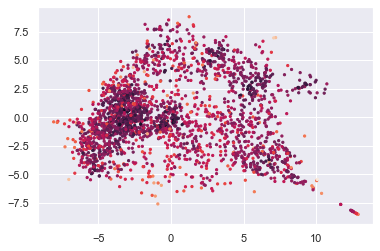

In [8]:
plt.scatter(*embedding.T, c=np.log(score), s=5)

<AxesSubplot:>

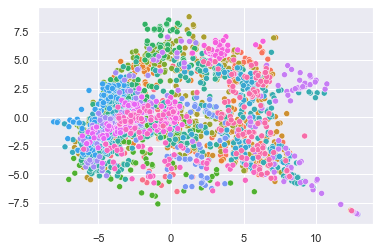

In [9]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df["actor"], legend=False)

<AxesSubplot:>

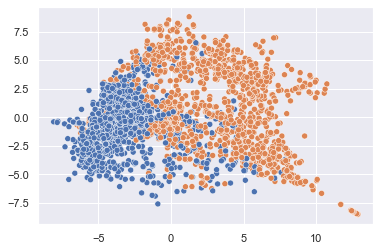

In [10]:
sns.scatterplot(x = embedding[:,0], y=embedding[:,1], hue=df["sex"], legend=False)

<AxesSubplot:>

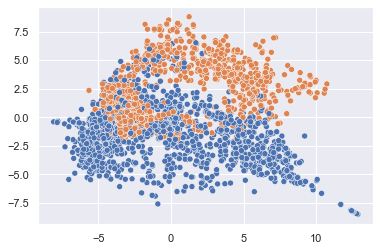

In [11]:
sns.scatterplot(x = embedding[:,0], y=embedding[:,1], hue=df["vocal_channel"], legend=False)

<AxesSubplot:>

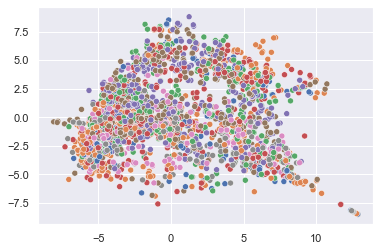

In [12]:
sns.scatterplot(x = embedding[:,0], y=embedding[:,1], hue=df["emotion"], legend=False)